In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook
import soundfile as sf

In [ ]:
!gdown https://drive.google.com/uc?id=13w41z23CUpT_sX0EzXaeSWL1kYRcbkcE

Downloading...
From: https://drive.google.com/uc?id=13w41z23CUpT_sX0EzXaeSWL1kYRcbkcE
To: /content/dataset_for_vad.zip
120MB [00:05, 20.6MB/s]


In [ ]:
!unzip -q dataset_for_vad

In [ ]:
from pathlib import Path
Noise_DIR = Path('dataset_for_vad/processed_noises')
Voice_DIR = Path('dataset_for_vad/processed_voices')
noise_files = sorted(list(Noise_DIR.rglob('*.wav')))
voice_files = sorted(list(Voice_DIR.rglob('*.wav')))


In [ ]:
amplitude, _ = librosa.load(voice_files[120], sr=8000)
melspec = librosa.feature.mfcc(amplitude, 8000, n_mfcc=5, n_fft=512, hop_length=80, win_length=200)
import matplotlib.pyplot as plt
import librosa.display
fig, ax = plt.subplots()
img = librosa.display.specshow(melspec, ax=ax)
fig.colorbar(img, ax=ax)

In [ ]:
amplitude, _ = librosa.load(voice_files[120], sr=8000)
melspec = librosa.feature.melspectrogram(amplitude, 8000, n_fft=512, hop_length=80, win_length=200)
import matplotlib.pyplot as plt
import librosa.display
fig, ax = plt.subplots()
img = librosa.display.specshow(melspec, ax=ax)
fig.colorbar(img, ax=ax)

In [ ]:
len(voice_files)

7501

In [ ]:
len(noise_files)

441

In [ ]:
import random

In [ ]:
X_train = []
X_valid = []
X_test = []
y_train = []
y_valid = []
y_test = []
for noise in noise_files:
  amp, sr =librosa.load(noise, sr=8000)
  # mfcc = librosa.feature.mfcc(amp, 8000, n_mfcc=5)
  mfcc = librosa.feature.melspectrogram(amp, 8000, n_fft=512, hop_length=80, win_length=200, window='hamming')

  rand = random.randint(0,100)
  if mfcc.shape!=(128,101):
  # if mfcc.shape!=(5,16):
    print("u suck")
  if rand>=90:
    X_test.append(mfcc)
    y_test.append(0)
  elif rand<=79:
    X_train.append(mfcc)
    y_train.append(0)
  else:
    X_valid.append(mfcc)
    y_valid.append(0)
for voice in voice_files:
  rand = random.randint(0,100)
  amp, sr =librosa.load(voice, sr=8000)
  mfcc = librosa.feature.melspectrogram(amp, 8000, n_fft=512, hop_length=80, win_length=200, window='hamming')
  # mfcc = librosa.feature.mfcc(amp, 8000, n_mfcc=5)
  if mfcc.shape!=(128,101):
  # if mfcc.shape!=(5,16):
    continue
  if rand>=90:
    X_test.append(mfcc)
    y_test.append(1)
  elif rand<=79:
    X_train.append(mfcc)
    y_train.append(1)
  else:
    X_valid.append(mfcc)
    y_valid.append(1)

In [ ]:
def generate_batches(X, y, batch_size=64):
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))
    for start in range(0, (len(X)//batch_size)*batch_size, batch_size):
      end = min(start + batch_size, len(X))
      batch_idx = perm[start:end]
      yield X[batch_idx], y[batch_idx]

In [ ]:
 class VAD(nn.Module):
  #  [128, 1, 80], expected input[256, 128, 150]
    def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv1d(128, 64, 101)
          self.bn1 = nn.BatchNorm1d(64)
          self.conv2 = nn.Conv1d(64, 256, 1)
          self.bn2 = nn.BatchNorm1d(256)
          self.conv3 = nn.Conv1d(256, 64, 1)
          self.bn3 = nn.BatchNorm1d(64)
          self.dropout1 = nn.Dropout(p=0.2)
          self.out = nn.Linear(64, 2)
          
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, X_train, y_train,  criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in generate_batches(X_train, y_train):
        inputs = torch.from_numpy(inputs).to(device, dtype=torch.float)
        labels = torch.from_numpy(labels).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, X_valid, y_valid, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in generate_batches(X_valid, y_valid):
        inputs = torch.from_numpy(inputs).to(device, dtype=torch.float)
        labels = torch.from_numpy(labels).to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(X_train, y_train, X_valid, y_valid, model, epochs):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.0005)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, X_train, y_train, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, X_valid, y_valid, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vad_model = VAD().to(device)
history = train(X_train, y_train, X_valid, y_valid, model=vad_model, epochs=25)

cuda


epoch:   4%|▍         | 1/25 [00:00<00:19,  1.26it/s]

loss 0.3171968473908828

Epoch 001 train_loss: 0.3172     val_loss 0.1562 train_acc 0.9243 val_acc 0.9544


epoch:   8%|▊         | 2/25 [00:01<00:16,  1.40it/s]

loss 0.06909116254231326

Epoch 002 train_loss: 0.0691     val_loss 0.0389 train_acc 0.9712 val_acc 0.9883


epoch:  12%|█▏        | 3/25 [00:01<00:14,  1.53it/s]

loss 0.03276251161953473

Epoch 003 train_loss: 0.0328     val_loss 0.0299 train_acc 0.9892 val_acc 0.9909


epoch:  16%|█▌        | 4/25 [00:02<00:12,  1.63it/s]

loss 0.019925718332254375

Epoch 004 train_loss: 0.0199     val_loss 0.0271 train_acc 0.9942 val_acc 0.9948


epoch:  20%|██        | 5/25 [00:02<00:11,  1.71it/s]

loss 0.01241761468622123

Epoch 005 train_loss: 0.0124     val_loss 0.0249 train_acc 0.9963 val_acc 0.9961


epoch:  24%|██▍       | 6/25 [00:03<00:10,  1.77it/s]

loss 0.008978049313864363

Epoch 006 train_loss: 0.0090     val_loss 0.0244 train_acc 0.9974 val_acc 0.9935


epoch:  28%|██▊       | 7/25 [00:03<00:09,  1.82it/s]

loss 0.00639785319143221

Epoch 007 train_loss: 0.0064     val_loss 0.0264 train_acc 0.9982 val_acc 0.9935


epoch:  32%|███▏      | 8/25 [00:04<00:09,  1.85it/s]

loss 0.004346043819393728

Epoch 008 train_loss: 0.0043     val_loss 0.0283 train_acc 0.9990 val_acc 0.9909


epoch:  36%|███▌      | 9/25 [00:04<00:08,  1.88it/s]

loss 0.0033217772134030757

Epoch 009 train_loss: 0.0033     val_loss 0.0332 train_acc 0.9994 val_acc 0.9909


epoch:  40%|████      | 10/25 [00:05<00:07,  1.90it/s]

loss 0.00294326056251455

Epoch 010 train_loss: 0.0029     val_loss 0.0379 train_acc 0.9995 val_acc 0.9909


epoch:  44%|████▍     | 11/25 [00:05<00:07,  1.91it/s]

loss 0.002701463632655063

Epoch 011 train_loss: 0.0027     val_loss 0.0441 train_acc 0.9995 val_acc 0.9896


epoch:  48%|████▊     | 12/25 [00:06<00:06,  1.90it/s]

loss 0.0024625220060747973

Epoch 012 train_loss: 0.0025     val_loss 0.0500 train_acc 0.9995 val_acc 0.9896


epoch:  52%|█████▏    | 13/25 [00:07<00:06,  1.91it/s]

loss 0.002239872389641181

Epoch 013 train_loss: 0.0022     val_loss 0.0552 train_acc 0.9995 val_acc 0.9896


epoch:  56%|█████▌    | 14/25 [00:07<00:05,  1.93it/s]

loss 0.0020169907922264092

Epoch 014 train_loss: 0.0020     val_loss 0.0594 train_acc 0.9995 val_acc 0.9896


epoch:  60%|██████    | 15/25 [00:08<00:05,  1.93it/s]

loss 0.001818757700962542

Epoch 015 train_loss: 0.0018     val_loss 0.0633 train_acc 0.9995 val_acc 0.9896


epoch:  64%|██████▍   | 16/25 [00:08<00:04,  1.91it/s]

loss 0.0016198439055689657

Epoch 016 train_loss: 0.0016     val_loss 0.0674 train_acc 0.9995 val_acc 0.9896


epoch:  68%|██████▊   | 17/25 [00:09<00:04,  1.92it/s]

loss 0.0014121632214824315

Epoch 017 train_loss: 0.0014     val_loss 0.0713 train_acc 0.9995 val_acc 0.9896


epoch:  72%|███████▏  | 18/25 [00:09<00:03,  1.93it/s]

loss 0.0011928733432416286

Epoch 018 train_loss: 0.0012     val_loss 0.0758 train_acc 0.9995 val_acc 0.9896


epoch:  76%|███████▌  | 19/25 [00:10<00:03,  1.92it/s]

loss 0.0009808374044901632

Epoch 019 train_loss: 0.0010     val_loss 0.0803 train_acc 0.9995 val_acc 0.9896


epoch:  80%|████████  | 20/25 [00:10<00:02,  1.93it/s]

loss 0.0008082066146328301

Epoch 020 train_loss: 0.0008     val_loss 0.0851 train_acc 0.9997 val_acc 0.9896


epoch:  84%|████████▍ | 21/25 [00:11<00:02,  1.93it/s]

loss 0.0006687251709911217

Epoch 021 train_loss: 0.0007     val_loss 0.0896 train_acc 0.9998 val_acc 0.9896


epoch:  88%|████████▊ | 22/25 [00:11<00:01,  1.94it/s]

loss 0.0005642134366082771

Epoch 022 train_loss: 0.0006     val_loss 0.0931 train_acc 0.9998 val_acc 0.9909


epoch:  92%|█████████▏| 23/25 [00:12<00:01,  1.93it/s]

loss 0.0005256589095141226

Epoch 023 train_loss: 0.0005     val_loss 0.1006 train_acc 0.9998 val_acc 0.9896


epoch:  96%|█████████▌| 24/25 [00:12<00:00,  1.94it/s]

loss 0.0005578726238722642

Epoch 024 train_loss: 0.0006     val_loss 0.1133 train_acc 0.9998 val_acc 0.9883


epoch: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]

loss 0.0005381971771682546

Epoch 025 train_loss: 0.0005     val_loss 0.1197 train_acc 0.9998 val_acc 0.9883


In [ ]:
def predict(model, X_test, y_test):
    with torch.no_grad():
        correct = 0
        total = 0 
        expect= []
        preds =[]
        for inputs, labels in zip(X_test, y_test):
            inputs = torch.from_numpy(inputs).to(device, dtype=torch.float)
            model.eval()
            output = model(inputs.unsqueeze(0)).cpu()
            output = torch.exp(output)
            prob = torch.max(output.data, 1)[0].numpy()[0]
            prediction = int(torch.max(output.data, 1)[1].numpy())
            preds.append(prediction)
            expect.append(labels)
    return preds, expect

In [ ]:
X_test = np.array(X_test)

In [ ]:
p, e = predict(vad_model, X_test, y_test) 

In [ ]:
total = 0
correct = 0
for pred, expected  in zip(p,e):
  if pred==expected:
    correct+=1
  total+=1
print("Accuracy: ", correct/total)

Accuracy:  0.9897959183673469


In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  fname = 'recorded_audio.wav'
  print('Saving to', fname)
  b = b64decode(data.split(',')[1])
  with open(fname, 'wb') as f:
    f.write(b)
  return fname

In [ ]:
def classify(model):
  audio, sr = librosa.load(get_audio(), sr=8000)
  non_silent_audio = []
  seconds = 0
  for i in range(len(audio)//8000):
    mfcc = librosa.feature.melspectrogram(audio[0+i*8000:8000+8000*i], 8000, n_fft=512, hop_length=80, win_length=200, window='hamming')
    inputs = torch.from_numpy(mfcc).to(device, dtype=torch.float)
    model.eval()
    output = model(inputs.unsqueeze(0)).cpu()
    output = torch.exp(output)
    prob = torch.max(output.data, 1)[0].numpy()[0]
    prediction = int(torch.max(output.data, 1)[1].numpy())
    print(f"Audio recording complete, guess it is {prediction}")
    if prediction==1:
      non_silent_audio.append(audio[0+i*8000:8000+8000*i])
    if prediction==0:
      non_silent_audio.append([0.0]*8000)
  
  
  non_silent_audio = np.array(non_silent_audio)
  trues = len(non_silent_audio)
  sf.write("nonsilent.wav", np.reshape(non_silent_audio, trues*8000),8000)


In [ ]:
classify(vad_model)

Saving to recorded_audio.wav


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 1
Audio recording complete, guess it is 1
Audio recording complete, guess it is 1
Audio recording complete, guess it is 1
Audio recording complete, guess it is 1
Audio recording complete, guess it is 1
Audio recording complete, guess it is 1
Audio recording complete, guess it is 1
Audio recording complete, guess it is 1
Audio recording complete, guess it is 0
Audio recording complete, guess it is 1
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0
Audio recording complete, guess it is 0


In [ ]:
import IPython

In [ ]:
IPython.display.Audio("recorded_audio.wav")

In [ ]:
IPython.display.Audio("nonsilent.wav")

In [ ]:
amp_nonsilent, _  = librosa.load('nonsilent.wav', sr=8000)
amp_dirty, _ = librosa.load('recorded_audio.wav', sr=8000)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

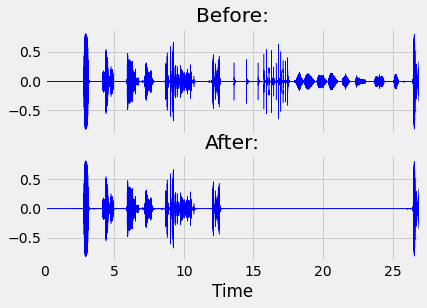

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.waveplot(amp_dirty, sr=8000, color='b', ax=ax[0])
ax[0].set(title='Before:')
ax[0].label_outer()
librosa.display.waveplot(amp_nonsilent, sr=8000, color='b', ax=ax[1])
ax[1].set(title='After:')
ax[1].label_outer()